# Dynamic Ride Pricing

### Overview
A ride-sharing company wants to implement a dynamic pricing strategy to optimize fares based on real-time market conditions. The company only uses ride duration to decide ride fares currently. The company aims to leverage data-driven techniques to analyze historical data and develop a predictive model that can dynamically adjust prices in response to changing factors.

### Dataset
The dataset provided for this project contains historical ride data and includes features such as the number of riders, number of drivers, location category, customer loyalty status, number of past rides, average ratings, time of booking, vehicle type, expected ride duration, and historical cost of the rides. These features will serve as the basis for developing the dynamic pricing model. You can download the data from [**here**](#https://statso.io/dynamic-pricing-case-study/).

### Objectives
1. Develop a predictive model that accurately estimates optimal fares for rides based on real-time market conditions and historical data.
2. Investigate the impact of various factors such as demand patterns, supply availability, and customer attributes on ride fares.
3. Implement a dynamic pricing strategy that adjusts fares in response to changing factors to maximize revenue and customer satisfaction.

### Methodology
1. **Data Collection and Preprocessing**: Gather comprehensive datasets and preprocess them by handling missing values, encoding categorical variables, and normalizing numerical features.
2. **Feature Engineering**: Extract relevant features and potentially create new ones to enhance the predictive power of the model, considering factors such as demand patterns and supply availability.
3. **Model Selection**: Explore various machine learning algorithms, including regression and ensemble methods, to identify the optimal model for dynamic pricing prediction.
4. **Model Training and Evaluation**: Train the selected model on the preprocessed dataset and evaluate its performance using appropriate metrics such as mean absolute error and root mean squared error.
5. **Dynamic Pricing Implementation**: Implement the trained model to dynamically adjust fares in real-time based on changing market conditions, demand patterns, and supply availability, ensuring optimal pricing for each ride.

### Libraries

In [2]:
# Ignore Warnings
import warnings


import dill

# Data Manipulation
import pandas as pd
import numpy as np
import os
# Imputation - RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

### Project Structure

1. [**Loading Data**](#first): Load the dataset from a file or source into a DataFrame for analysis.
2. [**Data Preprocessing**](#second): Handle any missing or erroneous data, perform data type conversions, and clean the dataset for further analysis.
3. [**Exploratory Data Analysis (EDA)**](#third): Explore the dataset to gain insights into its distribution, relationships, and patterns. Visualize key features and relationships between variables.
4. [**Feature Engineering**](#fifth): Create new features or transform existing ones to improve the predictive power of the model.
5. [**Data Splitting**](#sixth): Split the training dataset into features (x) and the target variable (y) to prepare for model training.
6. [**Model Training**](#seventh): Utilize machine learning algorithms to train a predictive model on the training data.
7. [**Model Evaluation**](#eighth): Evaluate the trained model's performance using appropriate metrics and techniques.


# <a id='first'></a> Loading Data

In [4]:
# Reading data from the CSV file into a DataFrame using the first column as the index 
df = pd.read_csv('D:\Data Science Project Practice\Dynamic Pricing/dynamic_pricing.csv')

# Displaying the first few rows of the DataFrame
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [10]:
# Initialize empty lists to store object and non-object columns
obj = []
ints = []

# Loop through DataFrame columns
for col in df.columns:
    # Check if column data type is object
    if df[col].dtype == 'object':
        # If object, append column name, unique values count, and count of missing values to 'obj' list
        obj.append((col, df[col].nunique(), df[col].isna().sum()))
    else:
        # If non-object, append column name, unique values count, and count of missing values to 'ints' list
        ints.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine the maximum length of 'obj' and 'ints' lists
max_len = max(len(obj), len(ints))

# Extend 'obj' and 'ints' lists with empty tuples to match the maximum length
obj.extend([('', '', '')] * (max_len - len(obj)))
ints.extend([('', '', '', '')] * (max_len - len(ints)))

# Create a dictionary with keys representing column categories and values representing lists of corresponding data
data = {
    'Categorical_columns': [x[0] for x in obj],
    'cat_cols_uniques': [x[1] for x in obj],
    'cat_cols_missing': [x[2] for x in obj],
    'Numeric_columns': [x[0] for x in ints],
    'int_cols_uniques': [x[1] for x in ints],
    'int_cols_missing': [x[2] for x in ints],
    'int_cols_skew': [x[3] for x in ints]
}

# Convert the dictionary into a pandas DataFrame
pd.DataFrame(data)




,Categorical_columns,cat_cols_uniques,cat_cols_missing,Numeric_columns,int_cols_uniques,int_cols_missing,int_cols_skew
0,Location_Category,3,0,Number_of_Riders,81,0,0.002167
1,Customer_Loyalty_Status,3,0,Number_of_Drivers,79,0,0.963204
2,Time_of_Booking,4,0,Number_of_Past_Rides,101,0,-0.008457
3,Vehicle_Type,2,0,Average_Ratings,151,0,-0.078754
4,,,,Expected_Ride_Duration,171,0,-0.139868
5,,,,Historical_Cost_of_Ride,1000,0,0.209580


Based on the analysis of the dataset:

- The dataset consists of 1000 entries with no missing values across all columns.
- It comprises both categorical and numerical features:
  - **Categorical Columns**:
    1. **Location_Category**: Represents the category of the ride location.
      - Unique Values: 3
      
    2. **Customer_Loyalty_Status**: Indicates the loyalty status of the customer.
      - Unique Values: 3
      
    3. **Time_of_Booking**: Indicates the time at which the ride was booked.
      - Unique Values: 4
      
    4. **Vehicle_Type**: Represents the type of vehicle used for the ride.
      - Unique Values: 2
      
  - **Numerical Columns**:
    1. **Number_of_Riders**: Indicates the number of riders for the ride.
      - Unique Values: 81
      
    2. **Number_of_Drivers**: Indicates the number of drivers available for the ride.
      - Unique Values: 79
      
    3. **Number_of_Past_Rides**: Represents the number of past rides taken by the customer.
      - Unique Values: 101
      
    4. **Average_Ratings**: Represents the average ratings received by the ride service.
      - Unique Values: 151
      
    5. **Expected_Ride_Duration**: Indicates the expected duration of the ride in minutes.
      - Unique Values: 171
      
    6. **Historical_Cost_of_Ride**: Represents the historical cost of the ride.
      - Unique Values: 1000

- The dataset provides a solid foundation for developing a dynamic pricing model for ride-sharing services. By leveraging both categorical and numerical features, the model can predict optimal fares based on real-time market conditions and historical data.


In [11]:
# This line of code retrieves the shape of the DataFrame 'df'
shape = df.shape
print(shape)

(1000, 10)


# <a id='second'></a> Data Preprocessing

In [12]:
# Displaying concise summary information about the DataFrame, including
# data types, non-null values, and memory usage
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [13]:
# Displaying the data types of each column in the DataFrame
df.dtypes

Number_of_Riders             int64
Number_of_Drivers            int64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides         int64
Average_Ratings            float64
Time_of_Booking             object
Vehicle_Type                object
Expected_Ride_Duration       int64
Historical_Cost_of_Ride    float64
dtype: object

In [14]:
# Counting the number of duplicated rows in the DataFrame and then counting
# the frequency of those counts to summarize the distribution of duplicated rows
df.duplicated().value_counts()


False    1000
Name: count, dtype: int64

In [15]:
df.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

# <a id='third'></a> Exploratory Data Analysis

In [16]:
# Generate descriptive statistics for all numerical columns
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [17]:
# Generate descriptive statistics for categorical columns
df.describe(include='object')

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


### Visualising Categorical and Numerical features distributions

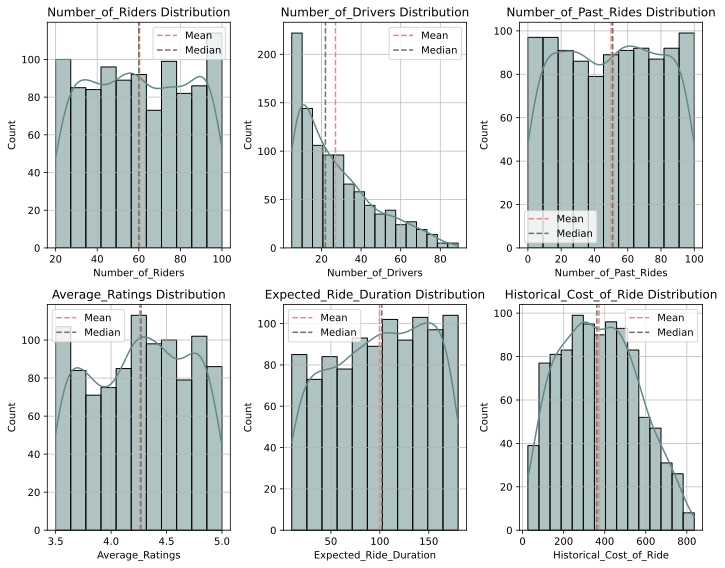

In [18]:
# Select numerical columns from the DataFrame
numerics = df.select_dtypes(include='number')

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)



# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each numerical column and create a histogram subplot
for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    mean_values = numerics[col].mean()
    median = numerics[col].median()

    sns.histplot(numerics[col], kde=True, color='#638889')  # Plot histogram using seaborn
    plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
    plt.axvline(x=median, color='#747264', linestyle='--', label='Median')
    plt.grid(True, alpha=0.8)  # Add grid lines to the plot
    plt.title(f'{col} Distribution')  # Set title for the subplot
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots


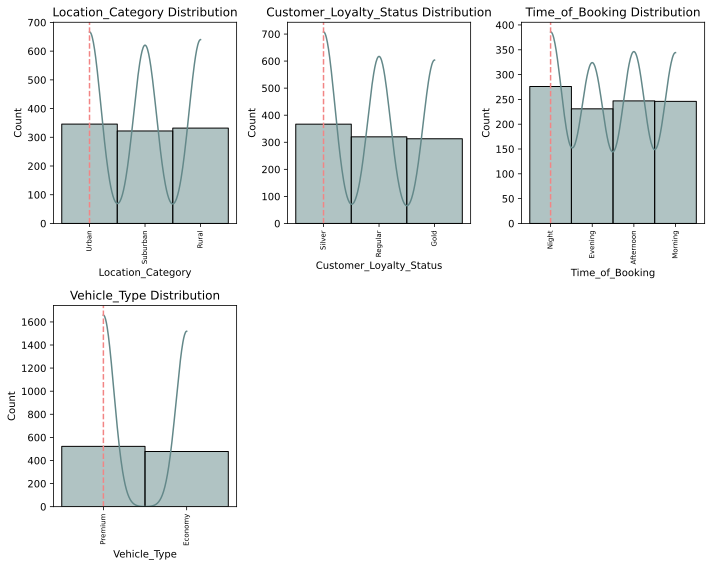

In [ ]:
# Select categorical columns from the DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(categorical_cols)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each categorical column and create a histogram subplot
for i, col in enumerate(df[categorical_cols], 1):
    mode = df[col].mode()[0]    
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    sns.histplot(df[col], kde=True, color='#638889')  # Plot histogram using seaborn

    plt.axvline(x=mode, color='#F28585', linestyle='--', label='Mode')

    plt.xticks(rotation=90, fontsize=7)  # Rotate x-axis labels for better readability
    plt.title(f'{col} Distribution')  # Set title for the subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots


### Outliers and Inconsistent Data

### Z-score Plot for Numerical Columns

This code snippet generates a series of subplots to visualize the distribution of Z-scores for each numerical column in the dataset. Z-score, also known as standard score, measures how many standard deviations an observation is from the mean. 

#### Steps:
1. **Select Numerical Columns**: Only the numerical columns are selected from the dataset using `select_dtypes` function.

2. **Calculate Plot Layout**: The number of subplots, rows, and columns are calculated based on the number of numerical columns.

3. **Set Figure Size**: The size of the figure is adjusted based on the number of rows.

4. **Iterate Through Numerical Columns**: For each numerical column, a subplot is created. Z-scores are calculated for each column and plotted against the index. A threshold line is drawn at Z-score of 3 and -3 to indicate outliers.

#### Interpretation:
- Points above the red dashed line (Z-score > 3) or below the red dashed line (Z-score < -3) are considered outliers.
- This visualization helps in identifying potential outliers in the dataset for each numerical feature.



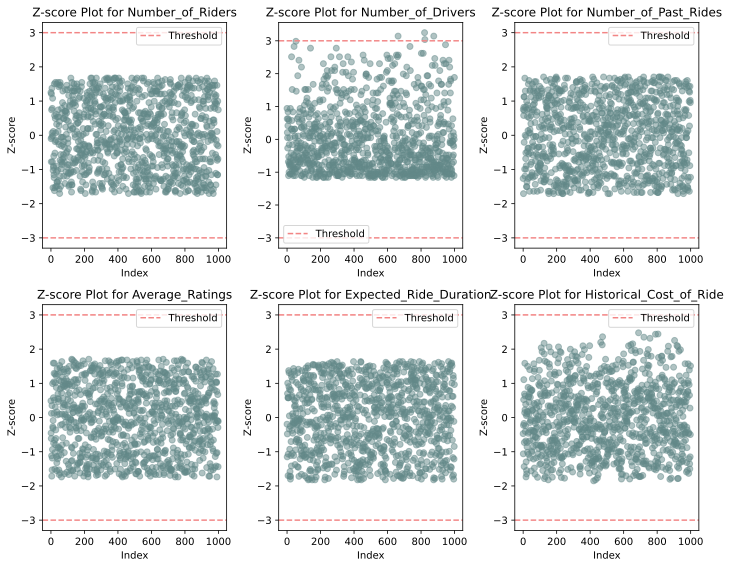

In [19]:
numerics = df.select_dtypes(include=np.number)

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  
    z_scores = (numerics[col] - numerics[col].mean()) / numerics[col].std()

    threshold = 3

    plt.scatter(np.arange(len(z_scores)), z_scores, color='#638889', alpha=0.5)
    plt.axhline(y=threshold, color='#F28585', linestyle='--', label='Threshold')
    plt.axhline(y=-threshold, color='#F28585', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.title(f'Z-score Plot for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

### Visualising correlation

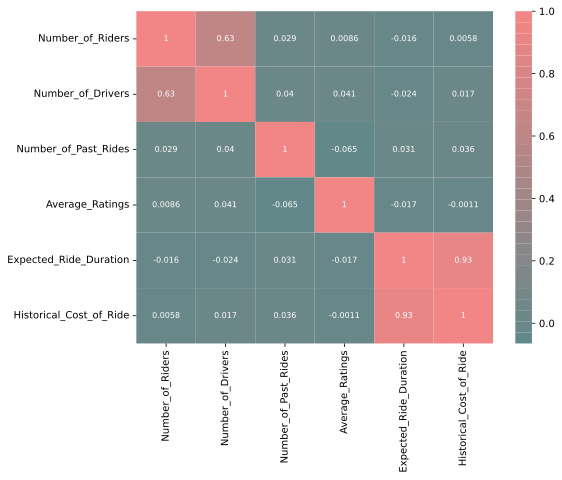

In [ ]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap of the correlation matrix for numerical columns in the dataframe
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, 
            cmap=['#638889', '#678788', '#6c8788', '#718788', '#768788',
                  '#7b8788', '#808788', '#858788', '#8a8787', '#8f8787',
                  '#948687', '#998687', '#9e8687', '#a38687', '#a88687',
                  '#ac8686', '#b18686', '#b68686', '#bb8686', '#c08686',
                  '#c58586', '#ca8586', '#cf8585', '#d48585', '#d98585',
                  '#de8585', '#e38585', '#e88585', '#ed8585', '#f28585'], annot_kws={"fontsize":8})

# Show the plot
plt.show()

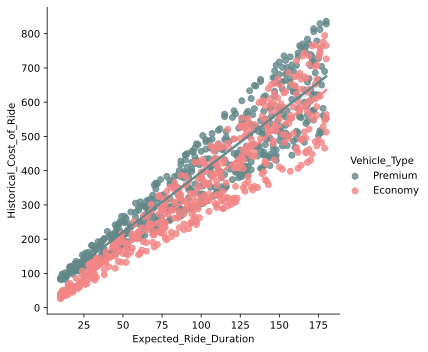

In [20]:
# Create a scatter plot with linear regression lines using seaborn's lmplot
sns.lmplot(data=df, y='Historical_Cost_of_Ride', x='Expected_Ride_Duration', hue='Vehicle_Type', 
           palette=['#638889', '#f28585'])

# Show the plot
plt.show()


# <a id='fifth'></a> Feature Engineering

### Dynamic Pricing Calculation

This section of code calculates the dynamic pricing adjustments for rides based on demand and supply factors. Here's a breakdown of the process:

1. **Demand Multiplier Calculation**:
   - `high_demand_percentile` and `low_demand_percentile` are defined to set the percentiles for high and low demand, respectively.
   - The `demand_multiplier` is calculated based on the percentile for high and low demand. For each ride, it compares the number of riders (`Number_of_Riders`) with the respective percentiles. If the number of riders is above the high demand percentile, it divides the number of riders by the high demand percentile value. If it's below the low demand percentile, it divides by the low demand percentile value.

2. **Supply Multiplier Calculation**:
   - Similar to demand, `high_supply_percentile` and `low_supply_percentile` are defined for setting the percentiles for high and low supply, respectively.
   - The `supply_multiplier` is calculated based on the percentile for high and low supply. For each ride, it compares the number of drivers (`Number_of_Drivers`) with the respective percentiles. If the number of drivers is above the low supply percentile, it divides the high supply percentile value by the number of drivers. If it's below the low supply percentile, it divides the low supply percentile value by the number of drivers.

3. **Price Adjustment Factors**:
   - `demand_threshold_high`, `demand_threshold_low`, `supply_threshold_high`, and `supply_threshold_low` are defined to set the thresholds for high and low demand/supply.

4. **Adjusted Ride Cost Calculation**:
   - The `adjusted_ride_cost` is calculated based on the historical cost of the ride (`Historical_Cost_of_Ride`) and the dynamic pricing adjustments determined by the demand and supply multipliers. It takes the maximum of demand multiplier and demand threshold low, and the maximum of supply multiplier and supply threshold high, then multiplies these values with the historical cost of the ride.

Overall, this process adjusts the ride cost dynamically based on demand and supply conditions to optimize pricing and maximize revenue.

In [21]:

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], 
                                                                           low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile)
                                   / df['Number_of_Drivers'], np.percentile(df['Number_of_Drivers'], 
                                                                            low_supply_percentile) 
                                   / df['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

In [22]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,1952.472427


### Profitability Analysis of Rides

This section of code analyzes the profitability of rides by comparing the adjusted ride cost (calculated using dynamic pricing) with the historical cost of the ride. Here's a breakdown of the process:

1. **Profit Percentage Calculation**:
   - The profit percentage for each ride is calculated using the formula:
   
     $
     \text{Profit Percentage} = \left( \frac{{\text{Adjusted Ride Cost} - \text{Historical Cost of Ride}}}{{\text{Historical Cost of Ride}}} \right) \times 100
     $
   - This formula computes the percentage increase or decrease in the cost of the ride after applying dynamic pricing compared to its historical cost.

2. **Identification of Profitable and Loss Rides**:
   - Profitable rides are identified where the profit percentage is positive.
   - Loss rides are identified where the profit percentage is negative.

3. **Counting of Profitable and Loss Rides**:
   - The count of profitable and loss rides is calculated.

4. **Visualization using Donut Chart**:
   - A donut chart is created to visualize the distribution of profitable and loss rides.
   - Labels and values are defined for 'Profitable Rides' and 'Loss Rides'.

Overall, this analysis provides insights into the impact of dynamic pricing on the profitability of rides, helping to understand the effectiveness of the pricing strategy in maximizing revenue.

In [23]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

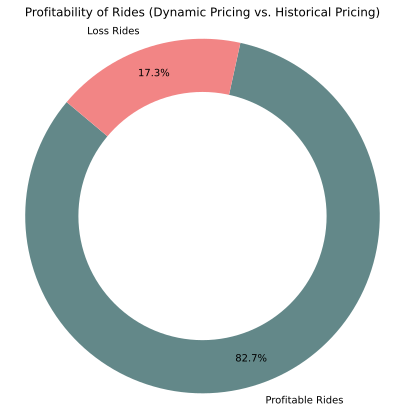

In [24]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

plt.figure(figsize=(7, 7))

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')


plt.show()

### Log Transformation of Target Variable

In this code snippet, the target variable `adjusted_ride_cost` is transformed using the natural logarithm plus one transformation (`np.log1p`). This transformation is commonly used to deal with skewed distributions and heteroscedasticity in regression analysis.

#### Log Transformation:
- The `np.log1p` function applies the natural logarithm transformation plus one to each value of the target variable `adjusted_ride_cost`.
- Adding one before taking the logarithm helps avoid errors when the original value is zero.

#### Benefits of Log Transformation:
- **Normalization**: Log transformation can help normalize the distribution of the target variable, making it more symmetric.
- **Homoscedasticity**: It can stabilize the variance of the target variable, making it more homoscedastic.
- **Linear Relationships**: Log-transformed variables often result in more linear relationships with predictor variables in regression models.

#### Considerations:
- Log transformation is suitable for variables with right-skewed or positively skewed distributions.
- However, it may not be appropriate for variables with zero or negative values.

In [25]:
# Calculate the skewness of the target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))


Skewness:  1.58


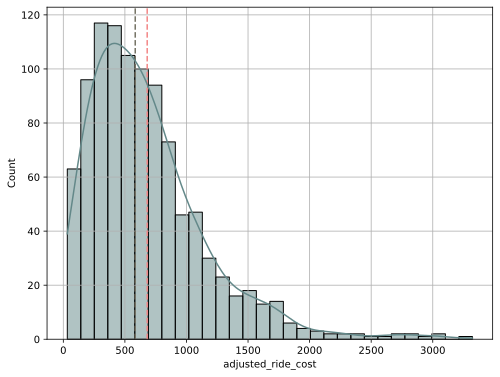

In [26]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))


# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_values = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Add vertical lines for mean and median to the plot
plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [30]:
# Apply the natural logarithm transformation plus 1 to the target variable 'TARGET'
df['adjusted_ride_cost'] = np.log1p(df['adjusted_ride_cost'])

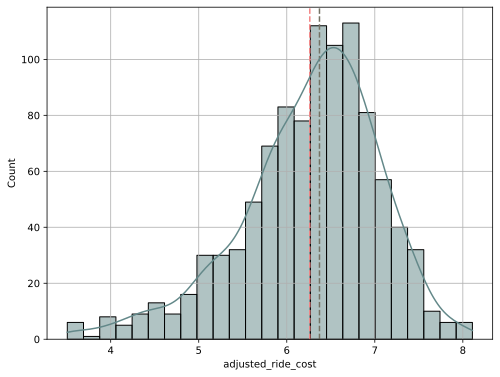

In [28]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))

# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_value = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Plot vertical lines indicating mean and median on the histogram plot
plt.axvline(x=mean_value, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [29]:
# Calculate the skewness of the transformed target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))


Skewness:  -0.72



### Box-Cox Transformation for Skewed Features

In this code snippet, a Box-Cox transformation is applied to skewed features in the dataset to reduce skewness and make the distribution more symmetric. Box-Cox transformation is a power transformation technique that is particularly effective for dealing with skewed data.

#### Steps:
1. **Estimating Lambda Parameter**: The lambda parameter for the Box-Cox transformation is estimated using `boxcox_normmax` function. Adding 2 to each value helps avoid non-positive values, which are not supported by the transformation.
2. **Applying Box-Cox Transformation**: The Box-Cox transformation is applied to the feature using the estimated lambda parameter, `lambda_est`.


#### Benefits of Box-Cox Transformation:
- **Skewness Reduction**: Box-Cox transformation helps reduce skewness in the distribution of the features.
- **Normalization**: It can make the distribution more symmetric, which is beneficial for many statistical analyses and machine learning algorithms.

#### Considerations:
- Box-Cox transformation assumes that the data is continuous and positive.
- It may not be suitable for features with zero or negative values.
- Care should be taken when estimating the lambda parameter, as incorrect estimation can lead to improper transformation.

In [31]:
# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  0.96


In [32]:
# Estimate the optimal Box-Cox transformation parameter lambda for 'Number_of_Drivers' column
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))

# Apply the Box-Cox transformation to the 'Number_of_Drivers' column using the estimated lambda
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))


Skewness:  -0.01


# <a id='sixth'></a> Data Splitting

In [33]:
# Create the TRAIN subset by selecting rows where the target variable TARGET is not null
TARGET = df['adjusted_ride_cost']

# Create the TEST subset by selecting rows where the target variable TARGET is null
df = df.drop(columns=['adjusted_ride_cost'])


In [34]:
# Count the number of columns for each data type and display the counts
df.dtypes.value_counts()


float64    6
object     4
int64      3
Name: count, dtype: int64

### Polynomial Feature Engineering

In this section of code, polynomial feature engineering is performed to create a new feature based on the relationship between the number of riders and the number of drivers. Here's a detailed explanation of the process:

1. **Mapping Vehicle Type**:
   - The 'Vehicle_Type' column in the DataFrame is mapped to numerical values. 'Economy' is assigned 0, and 'Premium' is assigned 1.

2. **Feature Selection**:
   - The feature matrix \( X \) is constructed from the DataFrame, including features such as 'Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', and 'Vehicle_Type'.

3. **Polynomial Fitting**:
   - A second-degree polynomial is fitted to the relationship between the number of riders and the number of drivers using the `np.polyfit()` function.
   - This step calculates the coefficients of the polynomial that best fits the data.

4. **Creating Polynomial Feature**:
   - A polynomial is created based on the coefficients obtained from the polynomial fitting using the `np.poly1d()` function.
   - This polynomial represents the relationship between the number of riders and the number of drivers.

5. **Calculating Interpolated Division**:
   - Values of the polynomial are computed for a new feature, 'interpolated_division', which is calculated as the division of the number of riders by the number of drivers.
   - This step effectively interpolates the division feature using the polynomial relationship.

6. **Conversion to Series**:
   - The interpolated division feature is converted back to a Series object and added to the DataFrame as a new column.

This process enhances the feature set by incorporating a derived feature that captures the complex relationship between the number of riders and the number of drivers, potentially improving the performance of machine learning models trained on this data.

In [ ]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})

# Assign the feature matrix X to the TRAIN DataFrame
X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]


# Fit a polynomial to a data set
coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)

# Создаем полином на основе коэффициентов
poly = np.poly1d(coefficients)

# Create a polynomial based on the coefficients
division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)


# Convert the result back to a Series
X['interpolated_division'] = pd.Series(division_feature)


### Standardizing Features with StandardScaler

In this section, we standardize the features in the dataset \(X\) using the StandardScaler class from scikit-learn.

1. **StandardScaler Instance Creation:**  
   An instance of StandardScaler named `scaler` is created using the StandardScaler class. This instance will be used to standardize the features.

2. **Feature Scaling:**  
   The `fit_transform` method of the `scaler` object is called with the feature matrix \(X\) as input. This method computes the mean and standard deviation of each feature in \(X\) and then standardizes the features by subtracting the mean and dividing by the standard deviation.

In [42]:
# Assign the target vector y to the non-null values of the TARGET variable
y = TARGET

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale the features in X using StandardScaler and fit_transform method
X_scaled = scaler.fit_transform(X)

os.makedirs("Data Science Project Practice/Dynamic Pricing", exist_ok=True)
#Now, save the scaler 
with open('Data Science Project Practice/Dynamic Pricing/scaler.pkl', 'wb') as file:
    dill.dump(scaler, file)
# Save the scaler to a file

In [ ]:

# Split the scaled features and the target variable y into training and testing sets
# The test set will be 30% of the total data, and the random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# <a id='seventh'></a> Model Training

### Model Evaluation with Grid Search and Cross-Validation

This code snippet demonstrates the process of evaluating multiple machine learning models using grid search and cross-validation. The goal is to find the best-performing model based on the R-squared score and root mean squared error (RMSE) on a test set.

#### Steps:
1. **Initialization**: 
   - An empty list `results` is initialized to store the evaluation results of each model.
   - Variables `best_model` and `best_r2` are initialized to track the best model and its R-squared score, respectively.

2. **Model Evaluation Loop**:
   - Iterate over each model in the `models` dictionary, which contains the names and instances of different machine learning models.
   - Create a pipeline with the current model.
   - Perform grid search with cross-validation using `GridSearchCV`. If hyperparameters are defined for the model in the `params` dictionary, grid search is performed with those hyperparameters; otherwise, default hyperparameters are used.
   - Fit the grid search to the training data.
   - Make predictions on the test set using the best model obtained from grid search.
   - Calculate the R-squared score and RMSE on the test set.
   - Update the `best_model` and `best_r2` variables if the current model performs better than the previous best model.
   - Append the evaluation results (model name, R-squared score, RMSE score, and best parameters) to the `results` list.

3. **Results DataFrame**:
   - Create a DataFrame `results_df` from the `results` list containing the evaluation results for each model.

#### Benefits:
- **Automated Model Selection**: Grid search with cross-validation automates the process of hyperparameter tuning, making it easier to find the best-performing model.
- **Comprehensive Evaluation**: The evaluation results include both R-squared score and RMSE, providing insights into model performance.

#### Considerations:
- **Computational Complexity**: Grid search with cross-validation can be computationally expensive, especially for large datasets and complex models.
- **Overfitting**: Care should be taken to prevent overfitting by using appropriate regularization techniques and validation strategies.


In [44]:
# Building Pipeline
# Dictionary containing regression models
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}

# Dictionary containing hyperparameter grids for each model
params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}


In [45]:
# Define a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Create a custom scorer 'rmse_scorer' using make_scorer
# 'greater_is_better=False' indicates that lower values of the scoring function are better
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# Initialize an empty list to store the results
results = []

# Initialize variables to track the best model and its R-squared score
best_model = None
best_r2 = float('-inf')

# Iterate over each model in the models dictionary
for name, model in models.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Check if hyperparameters for the current model are defined in the params dictionary
    if name in params:
        # If hyperparameters are defined, perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
        # If hyperparameters are not defined, perform grid search with default hyperparameters
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)
    
    # Calculate R-squared score and RMSE on the test set
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    rmse_val = rmse(np.expm1(y_test), np.expm1(y_pred))


    # Update the best model and its R-squared score if the current model performs better
    if r2 > best_r2:
        best_r2 = r2
        best_model = grid_search
    
    # Append the results to the results list
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'Best Parameters': grid_search.best_params_
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)


# <a id='eighth'></a> Model Evaluation

### Model Evaluation on Test Set

This code snippet demonstrates how to evaluate the best model selected during the grid search process on the test set. The evaluation metric used here is the R-squared (R2) score, which measures the proportion of the variance in the target variable that is predictable from the features.

#### Steps:
1. **Prediction**: 
   - Make predictions on the test set using the best model (`best_model.predict(X_test)`).

2. **R-squared Score Calculation**:
   - Calculate the R-squared (R2) score using the predicted values and true target values.
   - R-squared (R2) score measures the goodness-of-fit of the model, indicating how well the model explains the variability in the target variable.

#### Benefits:
- **Model Generalization Assessment**: The R-squared (R2) score on the test set provides insights into how well the model generalizes to unseen data.
- **Performance Communication**: Communicating the R-squared (R2) score allows stakeholders to understand the effectiveness of the predictive model.

#### Considerations:
- **Interpretation**: A higher R-squared (R2) score indicates better model performance, with values closer to 1 indicating a better fit. However, R-squared should be interpreted in the context of the problem domain and compared to alternative models.




In [47]:
# Set the display option to show all the contents of DataFrame columns without truncation
pd.set_option('display.max_colwidth', None)

# Set the display option to format float numbers with a precision of 5 decimal places
pd.set_option('display.float_format', '{:.5f}'.format)

# Display the DataFrame results_df
results_df


,Model,R-Squared Score,RMSE Score,Best Parameters
0,Ridge,0.64055,0.46869,{'model__alpha': 1.0}
1,Lasso,0.63622,0.47151,{'model__alpha': 0.001}
2,ElasticNet,0.63952,0.46937,"{'model__alpha': 0.001, 'model__l1_ratio': 0.2}"
3,SVR,0.76733,0.37709,"{'model__C': 10, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}"
4,RandomForestRegressor,0.91413,0.22908,{'model__n_estimators': 100}
5,XGBRegressor,0.93763,0.19524,"{'model__learning_rate': 0.1, 'model__max_depth': 3}"
6,CatBoostRegressor,0.94600,0.18166,"{'model__depth': 4, 'model__learning_rate': 0.01}"


In [48]:

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")


R-squared (R2): 0.9460017157867392


### Residual Plot for Model Evaluation

This section demonstrates the creation of a residual plot to evaluate the performance of a predictive model.

1. **Calculate Residuals:**  
   The residuals are calculated by subtracting the predicted target values from the true target values $ y_{\text{test}} - y_{\text{pred}} $. Since the target variable was log-transformed during training (`np.expm1`), it is first transformed back to its original scale before calculating the residuals.

2. **Calculate Standard Deviation of Residuals:**  
   The standard deviation $\sigma$ of the residuals is calculated using the `np.std` function.

3. **Create Hue List:**  
   A list is created for the `hue` parameter, which indicates whether the absolute value of each residual is less than the standard deviation (\(\sigma\)). This helps differentiate between residuals within one standard deviation of the mean and those outside it.

4. **Create Residual Plot:**  
   Using seaborn's `scatterplot` function, a scatter plot of residuals against predicted values is created. Residuals within one standard deviation of the mean are plotted in one color, while those outside it are plotted in another color. A horizontal dashed line is drawn at y=0 to represent the ideal case where residuals are centered around zero.


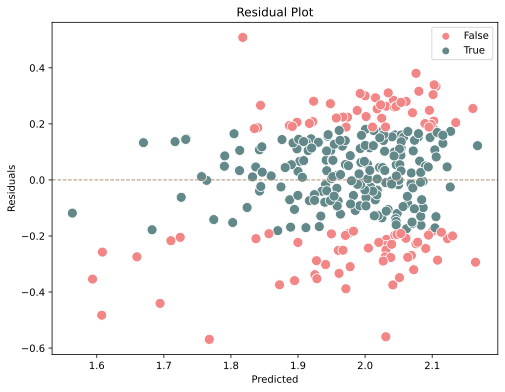

In [49]:
# Calculate residuals
residuals = np.expm1(y_test) - np.expm1(y_pred)

# Calculate standard deviation of residuals
sigma = np.std(residuals)

# Create a list for hue parameter
hue = list(map(lambda x: abs(x) < sigma, residuals))

# Create a residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, hue=hue, palette = ['#f28585', '#638889'], s=100)
plt.axhline(y=0, color='#A79277', linestyle='--', lw=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Hyperparameter Tuning

In [50]:
# # Define your CatBoostRegressor
# model = CatBoostRegressor()

# # Define the parameter distribution
# param_dist = {
#     'depth': np.arange(3, 11, 1),
#     'learning_rate': np.linspace(0.01, 0.1, 10),
#     'iterations': np.arange(30, 501, 20),
#     'l2_leaf_reg': np.arange(1, 6, 1),
#     'subsample': np.linspace(0.8, 1, 5)
# }

# # Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=150,  # Number of parameter settings that are sampled
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=0,
#     random_state=42,  # For reproducibility
#     n_jobs=-1
# )

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = random_search.best_params_
# print("Best parameters: ", best_params)

### Applying the Hyperparameters to the model and Visualizing the log Loss

In [51]:
# Create a CatBoostRegressor model with specified hyperparameters
model = CatBoostRegressor(verbose=0, subsample=0.9, learning_rate=0.05000000000000001, l2_leaf_reg=2,
                          iterations=350, depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract feature importances from the trained model
feature_coefficients = pd.DataFrame(model.feature_importances_, index=X.columns,
                                    columns=['Importance']).sort_values(by='Importance', ascending=False)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.9498950605268685


### Visualization of Validation RMSE Over Iterations

This section demonstrates the visualization of the Root Mean Squared Error (RMSE) values during the training process using the CatBoostRegressor model.

1. **Model Fitting with Evaluation Set:**  
   The model is fitted to the training data (`X_train`, `y_train`) with an evaluation set specified as (`X_test`, `y_test`). This allows the model to evaluate its performance on the validation set during training. The `use_best_model=True` parameter ensures that the best model based on validation performance is retained.

2. **Get Log Loss Values:**  
   After training, the RMSE values on the validation set for each iteration are obtained using the `get_evals_result()` method of the model. The RMSE values are extracted from the 'validation' dictionary.

3. **Plot Validation RMSE Over Iterations:**  
   Using matplotlib, a line plot is created to visualize the change in RMSE over iterations during training. The x-axis represents the number of iterations, while the y-axis represents the RMSE values. The plot helps in understanding how the model's performance on the validation set evolves over the training process.


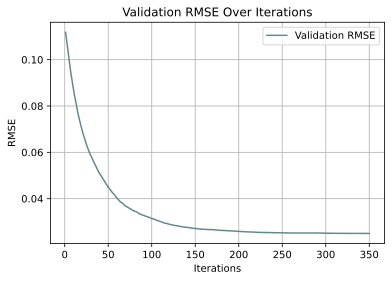

In [52]:
# Fit the model to the training data and evaluate it on the test set
# use_best_model=True ensures that the model uses the best iteration based on early stopping
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Get the RMSE values during training from the evaluation set
train_log_loss = model.get_evals_result()['validation']['RMSE']

# Plot RMSE over iterations
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(train_log_loss) + 1), train_log_loss, label='Validation RMSE', color='#638889')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Validation RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


### Visualizing Feature Importances

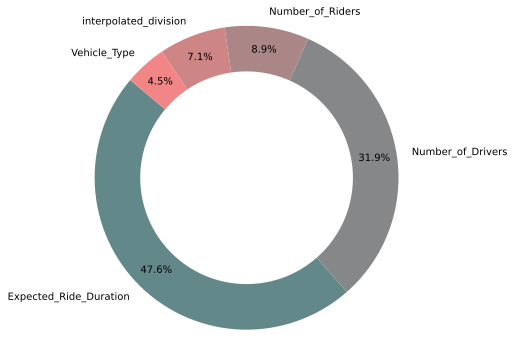

In [53]:
plt.figure(figsize=(6, 6))

# Create a pie chart
plt.pie(feature_coefficients['Importance'].values, labels=feature_coefficients.index, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#868788', '#aa8687', '#ce8586', '#f28585'], labeldistance = 1.1,
                pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()


### Prediction and Generation Submission



In [54]:
# Function to map vehicle type to numeric value
def get_vehicle_type_numeric(vehicle_type):
    # Define a mapping from vehicle type to numeric value
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    # Get the numeric value for the given vehicle type
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
# Predicting price using user input values
def predict_price(number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type):
    # Convert vehicle type to numeric representation
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    # Raise error if vehicle type is invalid
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    # Convert lists to numpy arrays for numerical computation
    number_of_riders = np.array(number_of_riders)
    number_of_drivers = np.array(number_of_drivers)
    
    # Fit a polynomial regression model to the data
    coefficients = np.polyfit(number_of_riders.ravel(), number_of_drivers.ravel(), deg=2)
    poly = np.poly1d(coefficients)
    
    # Calculate division feature
    division_feature = poly(number_of_riders / number_of_drivers)
    
    # Create input data array for prediction
    input_data = np.array([number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type_numeric, division_feature])
    
    # Reshape input data for compatibility with the model
    input = pd.DataFrame(input_data.reshape(1, -1))
    
    # Scale input data using scaler object
    scaled_input_data = scaler.transform(input)
    
    # Make price prediction using the model
    predicted_price = model.predict(scaled_input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 42
user_number_of_drivers = 31
user_vehicle_type = "Premium"
Expected_Ride_Duration = 76
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, Expected_Ride_Duration, user_vehicle_type)

# Print the predicted price
print("Predicted price:", np.expm1(predicted_price))


Predicted price: [6.13167884]


In [55]:

os.makedirs("Data Science Project Practice/Dynamic Pricing", exist_ok=True)
#Now, save the scaler 
with open('Data Science Project Practice/Dynamic Pricing/best_model.pkl', 'wb') as file:
    dill.dump(scaler, file)
# Save the scaler to a file

In [56]:
!pip freeze > requirements.txt

In [57]:
!python3 --version

Python 3.11.9


In [58]:
!which python3

'which' is not recognized as an internal or external command,
operable program or batch file.
